# ECE-6524 / CS-6524 Deep Learning
# Assignment 3

In this assignment, **you need to complete the Yolo loss function, and train an object detector. Yay!**

This assignment is inspired and adapted from [UIUC CS498](http://slazebni.cs.illinois.edu/fall18/assignment3_part2.html)
## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are displayed correctly there. 
7. Zip the all the files along with this notebook (Please don't include the data)
8. Name your PDF file as Assignment2_[YOUR ID NUMBER].
9. Submit your zipped file and the PDF **INDEPENDENTLY**.
10. **PLEASE DO NOT ZIP YOUR DATASET. ONLY NOTEBOOK/CODE/PDF.**

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here:  906161549
### Reference (if any):

In this homework, you would need to use **Python 3.6+** along with the following packages:
```
1. pytorch 1.2
2. torchvision
3. numpy
4. matplotlib
5. tqdm (for better, cuter progress bar. Yay!)
```
To install pytorch, please follow the instructions on the [Official website](https://pytorch.org/). In addition, the [official document](https://pytorch.org/docs/stable/) could be very helpful when you want to find certain functionalities. 


<span style="color:red">Note that, on a high-end GPU, it sill takes 3-4 hours to train. **SO START EARLY. IT'S IMPOSSIBLE TO FINISH IT AT THE LAST MINUTE!**</span>


In [1]:
# Google Colab stuff
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Google Colab stuff
# %cd "/content/drive/My Drive/Deep Learning/Homework/H3/Assignment_3/"

/content/drive/My Drive/Deep Learning/Homework/H3/Assignment_3


In [3]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(torch.__version__) 

1.3.0+cu100


## Initialization

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# You Only Look Once: Unified, Real-Time Object Detection [100 pts]
In this assignment, you need to implement the loss function and train the **YOLO object detector** (specfically, YOLO-v1). Here we provide a list of recommend readings for you:
- [YOLO original paper](http://slazebni.cs.illinois.edu/fall18/lec09_detection.pdf) (recommended)
- [Great post about YOLO](https://medium.com/adventures-with-deep-learning/yolo-v1-part-1-cfb47135f81f) on Medium
- [Differences between YOLO, YOLOv2 and YOLOv3
](https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)
- [Great explanation of the Yolo Loss function](https://stats.stackexchange.com/questions/287486/yolo-loss-function-explanation)
- [YOLO on SNL, suggested by UIUC CS498](https://www.youtube.com/watch?v=xZGahvrep3o)

We adopt a variant of YOLO, which:
1. Use pretrained ResNet50 classifier as detector backbone. The pretrained model is offered in `torchvision.models`.
2. Instead of using a $7\times7$ detection grid, we use $14\times14$ to get a more finegrained detection.

In general, the backbone models are usually pretrained on ImageNet dataset (> 1 million images) with numerous classes. As a result, having these pretrained backbone can greatly shorten the required training time, as well as improve the performance. <span style="color:red">**But still, it takes at least 3-4 hours to train, not to mention that you might need to debug after one training run. So START EARLY, DON'T GO #YOLO!**</span>

<img src="figure/example.png" width="450">
You are supposed to get a reasonable detector (like the ... above?) after training the model correctly.

In [0]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

## Load the pretrained ResNet classifier
Load the pretrained classifier. By default, it would use the pretrained model provided by `Pytorch`.

In [6]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


Some basic hyperparameter settings that you probably don't have to tune.

In [0]:
learning_rate = 0.001
num_epochs = 50
batch_size = 12

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5#5
lambda_noobj = 0.50#0.5

## Implement the YOLO-v1 loss [50 pts]
Now, you have to implement the `YoloLoss` for training your object detector. Please read closely to the [YOLO original paper](http://slazebni.cs.illinois.edu/fall18/lec09_detection.pdf) so that you can implement it.

In general, there are 4 components in the YOLO loss. Consider that we have our prediction grid of size$(N, S, S, 5B+c)$ ( (x, y, w, h, C) for each bounding box, and c is the number of classes), where $N$ is the batch size, $S$ is the grid size, $B$ is the number of bounding boxes. We have :
1. Bounding box regression loss on the bounding box$(x, y, w, h)$
    - $l_{coord}=\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{obj}_{ij}\left[(x_i-\hat{x}_i)^2+(y_i-\hat{y}_i)^2\right]$ + $\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{obj}_{ij}\left[(\sqrt{w_i}-\sqrt{\hat{w}_i})^2+(\sqrt{h_i}-\sqrt{\hat{h}_i})^2\right]$
    - $\mathbb{1}^{obj}_{ij}$: equals to 1 when object appears in cell $i$, and the bounding box $j$ is responsible for the prediction. 0 otherwise.
2. Contain object loss on the confidence prediction $c$ (only calculate for those boxes that actually have objects)
    - $l_{contain}=\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{obj}_{ij}(C_i-\hat{C}_i)^2$
    - $C_i$ the predicted confidence score for cell $i$ from predicted box $j$
    - For each grid cell, you only calculate the contain object loss for the predicted bounding box that has maximum overlap (iou) with the gruond truth box.
    - We say that this predicted box with maximum iou is **responsible** for the prediction.
3. No object loss on the confidence prediction $c$ (only calculate for those boxes that don't have objects)
    - $l_{noobj}=\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{noobj}_{ij}(C_i-\hat{C}_i)^2$
    - $\mathbb{1}^{obj}_{ij}$: equals to 1 when **no object appears** in cell $i$.
4. Classification error loss.
    - $l_{class}=\sum_{i=0}^{S^2}\mathbb{1}_i^{obj}\sum_{c\in classes}\left(p_i(c)-\hat{p_i}(c)\right)^2$
    - $p_i(c)$ is the predicted score for class $c$
    
Putting them together, we get the yolo loss:
\begin{equation}
yolo=\lambda_{coord}l_{coord}+l_{contain}+\lambda_{noobj}l_{noobj}+l_{class}
\end{equation}
where $\lambda$ are hyperparameters. We have provided detailed comments to gudie you through implementing the loss. So now, please complete the YoloLoss in the code block below. **If you have any problem with regard to implementation, post and discuss it on Piazza.**

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
 
class YoloLoss(nn.Module):
    def __init__(self,S,B,l_coord,l_noobj):
        super(YoloLoss,self).__init__()
        self.S = S
        self.B = B
        self.l_coord = l_coord
        self.l_noobj = l_noobj
 
    def compute_iou(self, box1, box2):                                                                                                                                                             
        '''Compute the intersection over union of two set of boxes, each box is [x1,y1,x2,y2].
        Args:
          box1: (tensor) bounding boxes, sized [N,4].
          box2: (tensor) bounding boxes, sized [M,4].
        Return:
          (tensor) iou, sized [N,M].
        '''
        N = box1.size(0)
        M = box2.size(0)
 
        lt = torch.max(
            box1[:,:2].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,:2].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )   
 
        rb = torch.min(
            box1[:,2:].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,2:].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )   
 
        wh = rb - lt  # [N,M,2]
        wh[wh<0] = 0  # clip at 0
        inter = wh[:,:,0] * wh[:,:,1]  # [N,M]
 
        area1 = (box1[:,2]-box1[:,0]) * (box1[:,3]-box1[:,1])  # [N,]
        area2 = (box2[:,2]-box2[:,0]) * (box2[:,3]-box2[:,1])  # [M,]
        area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
        area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]
 
        iou = inter / (area1 + area2 - inter)
        return iou 
    
    def get_class_prediction_loss(self, classes_pred, classes_target):
        """ 
        Parameters:
        classes_pred : (tensor) size (batch_size, S, S, 20)                                                                                                                                        
        classes_target : (tensor) size (batch_size, S, S, 20)
        
        Returns:
        class_loss : scalar
        """
         
        ##### CODE #####
        
        class_loss = torch.sum(torch.pow(classes_pred - classes_target, 2))
        
        return class_loss
         
    def get_regression_loss(self, box_pred_response, box_target_response):
        """
        Parameters:
        box_pred_response : (tensor) size (-1, 5)
        box_target_response : (tensor) size (-1, 5)
        Note : -1 corresponds to ravels the tensor into the dimension specified 
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as
         
        Returns:
        reg_loss : scalar
         
        """
        #[x,y,w,h,c] 
        ##### CODE #####
        xy_loss = torch.sum(torch.pow(box_pred_response[:,:2] - box_target_response[:,:2],2))
        
        wh_loss = torch.sum(torch.pow(torch.sqrt(box_pred_response[:,2:4]) - torch.sqrt(box_target_response[:,2:4]),2))
        reg_loss = self.l_coord*(xy_loss + wh_loss)
        
        return reg_loss
         
    def get_contain_object_loss(self, box_pred_response, box_target_response_iou):
        """
        Parameters:
        box_pred_response : (tensor) size ( -1 , 5)
        box_target_response_iou : (tensor) size ( -1 , 5)
        Note : -1 corresponds to ravels the tensor into the dimension specified 
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as
         
        Returns:
        contain_loss : scalar
         
        """
          
        ##### CODE #####
        contain_loss = torch.sum(torch.pow(box_pred_response[:,4] - box_target_response_iou[:,4], 2))

        return contain_loss
         
    def get_no_object_loss(self, target_tensor, pred_tensor, no_object_mask):
        """                                                                                                                                                                                        
        Parameters:
        target_tensor : (tensor) size (batch_size, S , S, 30)
        pred_tensor : (tensor) size (batch_size, S , S, 30)
        no_object_mask : (tensor) size (batch_size, S , S)
         
        Returns:
        no_object_loss : scalar
         
        Hints:
        1) Create 2 tensors no_object_prediction and no_object_target which only have the 
        values which have no object. 
        2) Have another tensor no_object_prediction_mask of the same size such that 
        mask with respect to both confidences of bounding boxes set to 1. 
        3) Create 2 tensors which are extracted from no_object_prediction and no_object_target using
        the mask created above to find the loss. 
        """
         
        ##### CODE #####
        no_object_prediction = pred_tensor[no_object_mask].unsqueeze(-1).view(-1,B*5+20)
        no_object_target = target_tensor[no_object_mask].unsqueeze(-1).view(-1,B*5+20)
        
        # Extract only the columns we care about - the confidences, column 4 and column 9:
        confidence_indices = torch.tensor([4,9]).to(device)
        no_object_prediction_confidences = torch.index_select(no_object_prediction, 1, confidence_indices)
        no_object_target_confidences = torch.index_select(no_object_target, 1, confidence_indices)
        
        # At this point, no_object_prediction/target_confidences are of size(n_no_object, 2)        
        no_object_prediction_mask = (no_object_prediction_confidences[:,0] > 0) | (no_object_prediction_confidences[:,1] > 0)
        no_object_prediction_mask = no_object_prediction_mask.unsqueeze(-1).expand_as(no_object_prediction_confidences)
        
        # We create the confidences mask, then mask to create the positive prediction confidences
        positive_prediction_confidences_on_pred = no_object_prediction_confidences[no_object_prediction_mask]
        positive_prediction_confidences_on_target = no_object_target_confidences[no_object_prediction_mask]
        
        no_object_loss = torch.sum(torch.pow(positive_prediction_confidences_on_pred - positive_prediction_confidences_on_target, 2))
        
        return no_object_loss * self.l_noobj
         
         
         
    def find_best_iou_boxes(self, box_target, box_pred):
        """
        Parameters: 
        box_target : (tensor)  size (-1, 5)
        box_pred : (tensor) size (-1, 5)
        Note : -1 corresponds to ravels the tensor into the dimension specified 
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as
         
        Returns: 
        box_target_iou: (tensor)
        contains_object_response_mask : (tensor)
         
        Hints:
        1) Find the iou's of each of the 2 bounding boxes of each grid cell of each image.
        2) Set the corresponding contains_object_response_mask of the bounding box with the max iou
        of the 2 bounding boxes of each grid cell to 1.
        3) For finding iou's use the compute_iou function
        4) Before using compute preprocess the bounding box coordinates in such a way that 
        if for a Box b the coordinates are represented by [x, y, w, h] then 
        x, y = x/S - 0.5*w, y/S - 0.5*h ; w, h = x/S + 0.5*w, y/S + 0.5*h
        Note: Over here initially x, y are the center of the box and w,h are width and height. 
        We perform this transformation to convert the correct coordinates into bounding box coordinates.
        5) Set the confidence of the box_target_iou of the bounding box to the maximum iou
         
        """
         
        ##### CODE #####
        # We get as input the box_target and box_pred which corresponds to size(n_cells_with_object, 5)
        
        # Pre-process box_target
        box_target_processed = torch.zeros(box_target.size())
        box_target_processed[:,0] = box_target[:,0]/float(self.S) - (0.5*box_target[:,2])
        box_target_processed[:,1] = box_target[:,1]/float(self.S) - (0.5*box_target[:,3])
        box_target_processed[:,2] = box_target[:,0]/float(self.S) + (0.5*box_target[:,2])
        box_target_processed[:,3] = box_target[:,1]/float(self.S) + (0.5*box_target[:,3])       
        
        # Remove that last element (c) in last dimension, we don't need it for now
        box_target_processed = box_target_processed[:,:-1]
        
        # Pre-process box prediction
        box_pred_processed = torch.zeros(box_pred.size())
        box_pred_processed[:,0] = box_pred[:,0]/float(self.S) - (0.5*box_pred[:,2])
        box_pred_processed[:,1] = box_pred[:,1]/float(self.S) - (0.5*box_pred[:,3])
        box_pred_processed[:,2] = box_pred[:,0]/float(self.S) + (0.5*box_pred[:,2])
        box_pred_processed[:,3] = box_pred[:,1]/float(self.S) + (0.5*box_pred[:,3])       
        
        # Remove the last element (c) in last dimension, we don't need it for now
        box_pred_processed = box_pred_processed[:,:-1]
        device = "cpu"
        # At this point, we have xyxy mappings of bounding boxes, both pred and target of size(n_cells_with_object*2, 4)
        # We are trying to find which grid cell will be in charge of that bounding box
        contains_object_response_mask = torch.cuda.BoolTensor(box_target.size()).fill_(False) # size(n_cells_with_object*2,5)
        contains_object_response_mask = contains_object_response_mask.to(device)
        
        
        box_target_iou = torch.zeros(box_target.size(), dtype=torch.float).to(device) 
        # The logic for this is: for each box in target, compute iou for proposed bboxes in each
        # cell relative to it. One thing of interest to note is each bbox [x,y,w,h] is the same in each
        # cell. Meaning we only need step-size of B. Due to the previous .view(-1,5) when passing into this function
        # the tensors look something like this, where bbox results are interleaved: 
        # pred = [[bbox1_cell1's xywh],[bbox2_cell1's xywh],[bbox1_cell2's xywh],[bbox2_cell2's xywh],...n]
        # target = [[bbox1_cell1's xywh],[bbox2_cell1's xywh],[bbox1_cell2's xywh],[bbox2_cell2's xywh],...n] where bbox1's xywh == bbox2's xywh for each cell
        for i in range(0, box_target_processed.size()[0], self.B):
          iou = self.compute_iou(box_pred_processed[i:i+B,:], box_target_processed[i,:].unsqueeze(0))
          max_val, max_index = iou.max(0)

          contains_object_response_mask[i+max_index] = True # Broadcast 1 into all the 5 elems of chosen row    
          box_target_iou[i+max_index, 4] = max_val # set confidence to max val
        device = "cuda"
        return box_target_iou, contains_object_response_mask
         

         
    def forward(self, pred_tensor,target_tensor):
        '''
        pred_tensor: (tensor) size(batchsize,S,S,Bx5+20=30)
                      where B - number of bounding boxes this grid cell is a part of = 2
                            5 - number of bounding box values corresponding to [x, y, w, h, c]
                                where x - x_coord, y - y_coord, w - width, h - height, c - confidence of having an object
                            20 - number of classes
         
        target_tensor: (tensor) size(batchsize,S,S,30)
         
        Returns:
        Total Loss
        '''
        
        N = pred_tensor.size(0)
        last_dim_size = target_tensor.size(-1) # this will be 30
        
        total_loss = None
        # Create 2 tensors contains_object_mask and no_object_mask 
        # of size (Batch_size, S, S) such that each value corresponds to if the confidence of having 
        # an object > 0 in the target tensor.
        
        ##### CODE #####
        # Please excuse the notes, I'm hoping to look back at them in the future (even 2 weeks from now I might forget...)
        # Slicing to get the 5th element of bounding box 1 and bounding box 2, the probability
        # of having an object. If probability is bigger than zero, yep it contains object (because this is ground truth)
        # If probability is zero, nope, no object, False.
        contains_object_mask = (target_tensor[:,:,:,4] > 0) | (target_tensor[:,:,:,9] > 0)
        no_object_mask = (target_tensor[:,:,:,4] == 0) & (target_tensor[:,:,:,9] == 0)
        
        # The reason we need this masks is because we only want to calculate loss and penalize the NN for 
        # incorrect predictions IF that particular bounding box has an object. Otherwise, there's no need
        # to penalize it at all. See the loss function here: https://medium.com/adventures-with-deep-learning/yolo-v1-part3-78f22bd97de4
        # This will be used to form the indicator function in front of the sums. This is what we are doing in the next snippet of code
        
        # Create a tensor contains_object_pred that corresponds to how long can i maintain google hangouts call
        # to all the predictions which seem to confidence > 0 for having an object
        # Then, split this tensor into 2 tensors :                                                                                                                                                       
        # 1) bounding_box_pred : Contains all the Bounding box predictions (x, y, w, h, c) of all grid 
        #                        cells of all images
        # 2) classes_pred : Contains all the class predictions for each grid cell of each image
        # Hint : Use contains_object_mask
        
        ##### CODE #####

        # Unsqueeze the last dimension, make it size(batchsize,S,S,1), then expand to the same size as target
        contains_object_mask = contains_object_mask.unsqueeze(-1).expand_as(target_tensor)
        
        # Mask predicted tensor with elems with object and change view, now we have size(num_contains_obj, 30)
        contains_object_pred = pred_tensor[contains_object_mask].view(-1, last_dim_size)
        
        # 5 * B because size(batchsize,S,S,Bx5+20=30), last dimension size is Bx5+20. We want the Bx5 elements only.
        bounding_box_pred = contains_object_pred[:,:5*B]
        # And the remainder is classes_pred
        classes_pred = contains_object_pred[:,5*B:]                     
        
        # Similarly, create 2 tensors bounding_box_target and classes_target
        # using the contains_object_mask.
    
        ##### CODE #####
        # Mask predicted tensor with elems with object and change view, now we have size(num_contains_obj, 30)
        contains_object_target = target_tensor[contains_object_mask].view(-1, last_dim_size)
        
        # 5 * B because size(batchsize,S,S,Bx5+20=30), last dimension size is Bx5+20. We want the Bx5 elements only.
        bounding_box_target = contains_object_target[:,:5*B]
        # And the remainder is classes_target
        classes_target = contains_object_target[:,5*B:] 
        
        #Compute the No object loss herehow long can i maintain google hangouts call
        # Instruction: finish your get_no_object_loss
        ##### CODE #####
        no_obj_loss = self.get_no_object_loss(target_tensor=target_tensor, pred_tensor=pred_tensor, no_object_mask=no_object_mask)        
        
        # Compute the iou's of all bounding boxes and the mask for which bounding box 
        # of 2 has the maximum iou the bounding boxes for each grid cell of each image.
        # Instruction: finish your find_best_iou_boxes and use it.
        ##### CODE #####
        # Split bounding box target into two, and bounding box pred into two
        box_target_iou, contains_object_response_mask = self.find_best_iou_boxes(box_target=bounding_box_target.contiguous().to(device).view(-1,5), 
                            box_pred=bounding_box_pred.contiguous().to(device).view(-1,5))
        
#         import pdb; pdb.set_trace()
        # Create 3 tensors :
        # 1) box_prediction_response - bounding box predictions for each grid cell which has the maximum iou
        # 2) box_target_response_iou - bounding box target ious for each grid cell which has the maximum iou
        # 3) box_target_response -  bounding box targets for each grid cell which has the maximum iou
        # Hint : Use coo_response_mask
        
        ##### CODE #####
        # Similar to before, this time masking for the bounding box in the prediction with largest iou
        box_target_iou = box_target_iou.detach()
        
        box_prediction_response = bounding_box_pred.contiguous().to(device).view(-1,5)[contains_object_response_mask].view(-1,5).to(device) # N x 5
        box_target_response = bounding_box_target.contiguous().to(device).view(-1,5)[contains_object_response_mask].view(-1,5).to(device) # N x 5
        box_target_response_iou = box_target_iou[contains_object_response_mask].view(-1, 5).to(device) # N x 1
        
        # Test loss on other box
        other_boxes = bounding_box_pred.contiguous().to(device).view(-1,5)[~contains_object_response_mask].view(-1,5).to(device)
        other_loss = torch.sum(torch.pow(other_boxes[:, 4],2))
                                                                                                                         
        # Find the class_loss, containing object loss and regression loss
        
        ##### CODE #####
        class_loss = self.get_class_prediction_loss(classes_pred, classes_target)
        contain_object_loss = self.get_contain_object_loss(box_prediction_response, box_target_response_iou)
        regression_loss = self.get_regression_loss(box_prediction_response, box_target_response)

        total_loss = no_obj_loss + contain_object_loss + class_loss + regression_loss + other_loss
        return total_loss / N

In [0]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset. Use `download_data.sh` to download the dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is a $(S, S, 5B+c)$ tensor, we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [10]:
file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)

train_dataset_len = len(train_dataset)
reduced_train_dataset = torch.utils.data.Subset(train_dataset, [0])

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
reduced_train_loader = DataLoader(reduced_train_dataset,batch_size=2,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [11]:
file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)

# Since we're only training on so few images, it'll definitely overfit to those 10 images, so we need to feed it those images(from the trainset) for it to test positive
reduced_test_loader = DataLoader(reduced_train_dataset,batch_size=2,shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


## Train detector
Now, train your detector.

In [13]:
best_test_loss = np.inf
for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
#     for i, (images, target) in enumerate(tqdm(reduced_train_loader, total=len(reduced_train_loader))):
    for i, (images, target) in enumerate(tqdm(train_loader, total=len(train_loader))):
        images, target = images.to(device), target.to(device)
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch [%d/%d], average_loss: %.4f'
            % (epoch+1, num_epochs, total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(tqdm(test_loader, total=len(test_loader))):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')
    


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 1 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [1/50], average_loss: 8.2590


100%|██████████| 413/413 [03:02<00:00,  2.67it/s]


Updating best test loss: 5.01935


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 2 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [2/50], average_loss: 4.7600


100%|██████████| 413/413 [03:02<00:00,  2.66it/s]


Updating best test loss: 4.60058


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 3 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [3/50], average_loss: 4.2878


100%|██████████| 413/413 [03:02<00:00,  2.66it/s]


Updating best test loss: 4.33054


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 4 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [4/50], average_loss: 4.0581


100%|██████████| 413/413 [03:02<00:00,  2.67it/s]


Updating best test loss: 3.96539


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 5 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [5/50], average_loss: 3.7322


100%|██████████| 413/413 [03:02<00:00,  2.68it/s]


Updating best test loss: 3.75295


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 6 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [6/50], average_loss: 3.5649


100%|██████████| 413/413 [03:02<00:00,  2.67it/s]


Updating best test loss: 3.60283


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 7 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [7/50], average_loss: 3.4147


100%|██████████| 413/413 [03:02<00:00,  2.66it/s]


Updating best test loss: 3.45046


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 8 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [8/50], average_loss: 3.2399


100%|██████████| 413/413 [03:02<00:00,  2.66it/s]


Updating best test loss: 3.39024


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 9 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [9/50], average_loss: 3.1428


100%|██████████| 413/413 [03:02<00:00,  2.68it/s]


Updating best test loss: 3.26046


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 10 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [10/50], average_loss: 3.0318


100%|██████████| 413/413 [03:02<00:00,  2.67it/s]


Updating best test loss: 3.22450


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 11 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [11/50], average_loss: 2.9342


100%|██████████| 413/413 [03:02<00:00,  2.67it/s]


Updating best test loss: 3.11341


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 12 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [12/50], average_loss: 2.8407


100%|██████████| 413/413 [03:02<00:00,  2.67it/s]


Updating best test loss: 3.09507


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 13 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [13/50], average_loss: 2.7887


100%|██████████| 413/413 [03:02<00:00,  2.68it/s]


Updating best test loss: 3.05158


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 14 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [14/50], average_loss: 2.7758


100%|██████████| 413/413 [03:02<00:00,  2.66it/s]


Updating best test loss: 3.04075


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 15 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [15/50], average_loss: 2.6898


100%|██████████| 413/413 [03:02<00:00,  2.67it/s]


Updating best test loss: 2.99392


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 16 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [16/50], average_loss: 2.6349


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 17 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [17/50], average_loss: 2.6139


100%|██████████| 413/413 [03:02<00:00,  2.69it/s]


Updating best test loss: 2.97466


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 18 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [18/50], average_loss: 2.5416


100%|██████████| 413/413 [03:02<00:00,  2.66it/s]


Updating best test loss: 2.94302


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 19 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [19/50], average_loss: 2.5235


100%|██████████| 413/413 [03:01<00:00,  2.70it/s]


Updating best test loss: 2.93188


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 20 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [20/50], average_loss: 2.4471


100%|██████████| 413/413 [03:01<00:00,  2.68it/s]


Updating best test loss: 2.88836


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 21 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [21/50], average_loss: 2.4440


100%|██████████| 413/413 [03:02<00:00,  2.67it/s]


Updating best test loss: 2.88250


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 22 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [22/50], average_loss: 2.3861


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 23 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [23/50], average_loss: 2.3819


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 24 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [24/50], average_loss: 2.3448


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 25 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [25/50], average_loss: 2.3164


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 26 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [26/50], average_loss: 2.2767


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 27 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [27/50], average_loss: 2.2792


100%|██████████| 413/413 [03:01<00:00,  2.70it/s]


Updating best test loss: 2.85280


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 28 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [28/50], average_loss: 2.2457


100%|██████████| 413/413 [03:01<00:00,  2.68it/s]


Updating best test loss: 2.84844


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 29 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [29/50], average_loss: 2.2090


100%|██████████| 413/413 [03:02<00:00,  2.69it/s]


Updating best test loss: 2.84045


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 30 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [30/50], average_loss: 2.2200


100%|██████████| 413/413 [03:01<00:00,  2.70it/s]


Updating best test loss: 2.82804


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 31 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [31/50], average_loss: 2.1008


100%|██████████| 413/413 [03:02<00:00,  2.67it/s]


Updating best test loss: 2.74936


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 32 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [32/50], average_loss: 2.0635


100%|██████████| 413/413 [03:01<00:00,  2.68it/s]


Updating best test loss: 2.74625


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 33 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [33/50], average_loss: 2.0239


100%|██████████| 413/413 [03:01<00:00,  2.70it/s]


Updating best test loss: 2.73138


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 34 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [34/50], average_loss: 2.0188


100%|██████████| 413/413 [03:01<00:00,  2.68it/s]


Updating best test loss: 2.72700


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 35 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [35/50], average_loss: 2.0118


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 36 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [36/50], average_loss: 1.9832


100%|██████████| 413/413 [03:02<00:00,  2.68it/s]


Updating best test loss: 2.70846


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 37 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [37/50], average_loss: 1.9563


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 38 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [38/50], average_loss: 1.9490


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 39 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [39/50], average_loss: 1.9641


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 40 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [40/50], average_loss: 1.9530


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 41 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [41/50], average_loss: 1.9169


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 42 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [42/50], average_loss: 1.9330


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 43 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [43/50], average_loss: 1.8863


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 44 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [44/50], average_loss: 1.9219


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 45 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [45/50], average_loss: 1.9354


100%|██████████| 413/413 [03:01<00:00,  2.70it/s]


Updating best test loss: 2.69737


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 46 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [46/50], average_loss: 1.9059


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 47 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [47/50], average_loss: 1.8957


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 48 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [48/50], average_loss: 1.9280


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 49 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [49/50], average_loss: 1.9125


  0%|          | 0/418 [00:00<?, ?it/s]



Starting epoch 50 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [50/50], average_loss: 1.9115


100%|██████████| 413/413 [03:01<00:00,  2.69it/s]


# View example predictions

Now, take a glance at how your detector works:

predicting...
(375, 500, 3)
[[(0, 3), (246, 368), 'person', '006903.jpg', 0.4994244873523712], [(240, 36), (442, 329), 'dog', '006903.jpg', 0.3978172540664673], [(65, 148), (252, 362), 'dog', '006903.jpg', 0.38506484031677246], [(221, -17), (466, 213), 'person', '006903.jpg', 0.1696045994758606]]


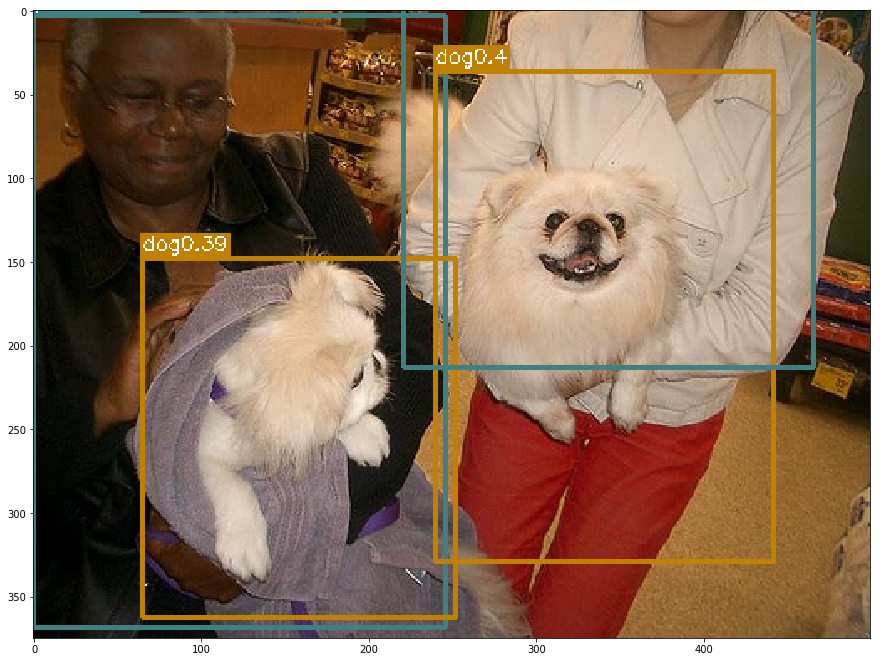

In [38]:
net.eval()
net.load_state_dict(torch.load('best_detector.pth'))
# select random image from train set
# train on small section
# import pdb; pdb.set_trace()

image_name = random.choice(train_dataset.fnames)
# image_name = '000005.jpg'
image = cv2.imread(os.path.join(file_root_train, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
threshold = 0.10
print('predicting...')
print(image.shape)
result = predict_image(net, image_name, root_img_directory=file_root_train, threshold=threshold)
print(result)

for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test [50 pts]

To evaluate detection results we use mAP (mean of average precision over each class), You are expected to get an map of at least 49.

In [37]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, threshold=threshold)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [05:28<00:00, 14.98it/s]


---class aeroplane ap 0.5561767921483016---
---class bicycle ap 0.6159982009690316---
---class bird ap 0.5010359713522582---
---class boat ap 0.30858187486088384---
---class bottle ap 0.27346758724543996---
---class bus ap 0.6149272805615849---
---class car ap 0.6917657581044496---
---class cat ap 0.7115034163425111---
---class chair ap 0.2885294240047017---
---class cow ap 0.5116756792210753---
---class diningtable ap 0.37320450604152927---
---class dog ap 0.6562862713645868---
---class horse ap 0.6870416450206072---
---class motorbike ap 0.5749797918298993---
---class person ap 0.5651248206847839---
---class pottedplant ap 0.26412457875323764---
---class sheep ap 0.49738550153952066---
---class sofa ap 0.48288061188451725---
---class train ap 0.6822793597535906---
---class tvmonitor ap 0.4384041056499897---
---map 0.514768658866625---
